In [3]:
#Installing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Data Preprocessing



In [2]:
data = pd.read_csv("loan.csv")

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [46]:
len(data.purpose.value_counts())

14

**Null Values**

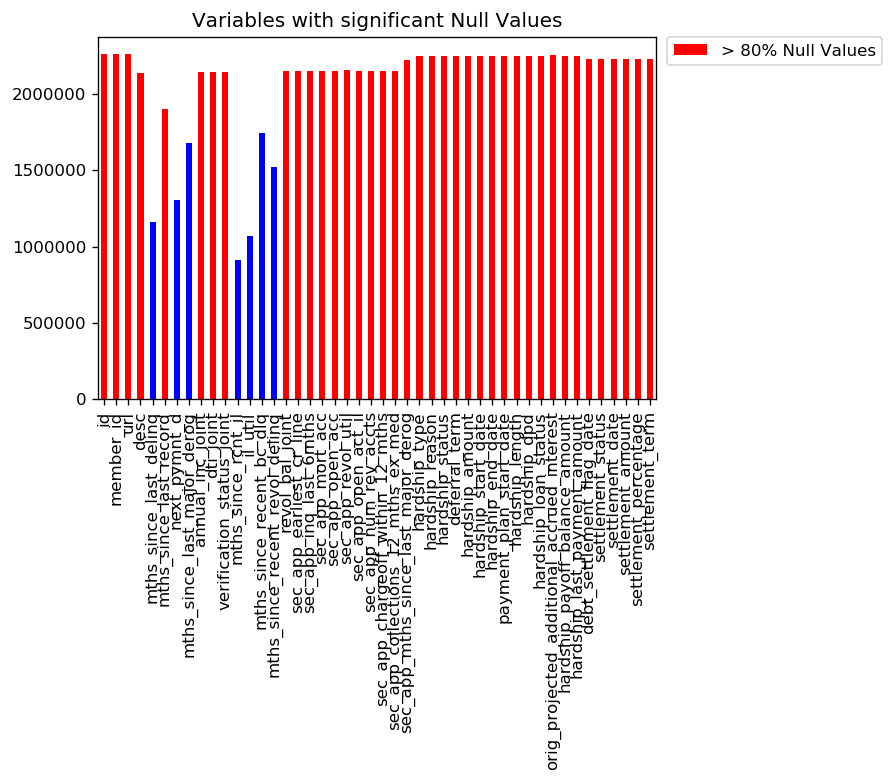

In [3]:
na_col = data.isnull().sum()
na_col = na_col[na_col >0.4*len(data)]
na_col
col_val = []
tr = len(data)
j=0
for i in na_col:
  if i/tr > 0.8:
    col_val.append("r")
    j +=1
  else:
    col_val.append("b")
plt.figure(dpi=120)
na_col.plot(kind='bar', color = tuple(col_val))
plt.show
plt.title("Variables with significant Null Values")
plt.legend(["> 80% Null Values"], bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

**Dropping** the columns with more than 80% of missing values and the unnecesary columns Unnamed: 0, id and url.

In [3]:
length = len(data)
data.drop(data.loc[:,data.isnull().sum()/length >.8], inplace=True, axis=1)

Dropping all the rows with many missing values (100)

In [4]:
na_rows = data[data.isnull().sum(axis=1)>100].index
data.drop(na_rows, inplace=True)

Dropping accounts where the issue_d is from Aug to December 2018 because they need to meet the 1 year requirement to show their behaivor. Because we are preddicting the PD for an application scoring use case the user need to has at least one year of history + 3 month to reveal its behavior. However, if they defaulted already we will keep them because they have already shown their behaviour

In [5]:
issued_less_than_15mths = data[((data.issue_d == "Dec-2018") | (data.issue_d == "Nov-2018") |(data.issue_d == "Aug-2018") |(data.issue_d == "Sep-2018") |
                                (data.issue_d == "Oct-2018")) & (data.loan_status != "Charged Off")].index
data.drop(issued_less_than_15mths, inplace=True)

The variable “grade” is not a predictive variable, for example, as it includes the business logic by Lending Club.

The variable “grade” and "sub_grade" is not a predictive variable, for example, as it includes the business logic by Lending Club.

In [6]:
data.drop(["grade", "sub_grade"], axis=1, inplace=True)

Eliminating users that does not meet policy requirements because the bank will never give to these users a loan

In [7]:
no_meeting_policy = data[data.loan_status.str.contains('Status:')].index
data.drop(no_meeting_policy, inplace=True)

emp_title will be drop because it has more than 200 categories and some of them don't have 5% of the population meaning it is not a significant variable. Also, some information contains wrong information, for instance there is one value that says "I am the director".

In [8]:
data.drop(['emp_title'], inplace=True, axis=1)

In [9]:
# extracting the first 3 values of the zip code. 
data['zip_code'] = data['zip_code'].str.extract(r'([\d\.]+)')

# extracting the numeric values of term
data['term'] = data['term'].str.extract(r'([\d\.]+)')

In [10]:
data.issue_d

5040       Dec-2018
25963      Dec-2018
41393      Nov-2018
55148      Nov-2018
58105      Nov-2018
             ...   
2260663    Oct-2017
2260664    Oct-2017
2260665    Oct-2017
2260666    Oct-2017
2260667    Oct-2017
Name: issue_d, Length: 2044690, dtype: object

In [11]:
data['default'] = np.nan
bad_loan = ["Charged Off", "Default"]

def loan_status(status):
  if status in bad_loan:
    return  1
  else:
    return 0
  
data['default'] = data['loan_status'].apply(loan_status)

After analizing the all the variables, to make the prediction we only need to take into the account the variables that we have at the moment the person asks for the loan which are the following:

'loan_amnt', 'installment', 'emp_length', 'home_ownership', 'purpose',
'annual_inc',  'term', 'addr_state', 'dti', 'delinq_2yrs', 
'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 
'revol_util', 'total_acc', 'verification_status', 'mths_since_rcnt_il',
'inq_fi'

In [12]:
col=['default','loan_amnt', 'installment', 'emp_length', 'home_ownership', 'purpose',
'annual_inc',  'term','zip_code','addr_state', 'dti', 'delinq_2yrs', 
'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 
'revol_util', 'total_acc', 'mths_since_rcnt_il',
'inq_fi', 'max_bal_bc']

data = data[col]

**Missing Values**

There were variables with around 40% missing values, in this case zero was used as neutral replacement for the missing data. For instance, months since recent installment account was opened, it can be inferred that the missing value is because the user have not opened an account, this means the product did not even existed, hence the zero-set was applied. Finally, for the categorical variables the missing values were replaced with the mode of the non-empty records. One example is the employment length, people with less years in their job are riskier because it is more likely that they do not have a stable income. Hence it is not reasonable to assign them a zero hence it was replaced with the mode.

In [13]:
null_counts = data.isnull().mean()
print("Number of null values in each column:\n{}".format(100*(null_counts)))

Number of null values in each column:
default                0.000000
loan_amnt              0.000000
installment            0.000000
emp_length             6.259971
home_ownership         0.000000
purpose                0.000000
annual_inc             0.000000
term                   0.000000
zip_code               0.000049
addr_state             0.000000
dti                    0.062650
delinq_2yrs            0.000000
inq_last_6mths         0.000049
open_acc               0.000000
pub_rec                0.000000
revol_bal              0.000000
revol_util             0.074192
total_acc              0.000000
mths_since_rcnt_il    43.997281
inq_fi                42.225472
max_bal_bc            42.225472
dtype: float64


The numeric variables with less than 4% of missing values will be filled with the median of that variable. Such as debt to income ratio (DTI) borrowers with lower ratio are less risky than those with high ratio. Hence it is unreasonable to assign them a zero, so using the median is better because is robust to outliers. 

In [14]:
num_var = data.drop(['default'], axis=1).select_dtypes(include = [np.number])
null_nv = num_var.isnull().mean()*100

In [15]:
for i in num_var:
  if (null_nv[i] < 6) & (null_nv[i]> 0.000045):
    data[i].fillna(data[i].median(), inplace=True)
    

The other numeric variables with significant missing values after analyzing them they will be filled with 0 because it made references to products that the client does not have.

In [16]:
for i in num_var:
  if (null_nv[i] > 6):
    data[i].fillna(0, inplace=True)

The only missing value in zip code is where the state is AL, so it will be replaced with the mode when the addr_state is AL

In [17]:
zip_al = data[data.addr_state == "AL"].zip_code.mode().values[0]
data.zip_code.fillna(zip_al, inplace=True)

I will replace employment date with the mode eventhough there are 6% of null cases value but it will be worst if we dropped this values

In [18]:
emp = data.emp_length.mode().values[0]
data.emp_length.fillna(emp, inplace=True)

**Outliers**

In this step we will remove the outliers. 
In some variables there are some points that our data can not represent, for example annual income between 500k and 1 million. 

In [19]:
data.shape

(2044690, 21)

In [20]:
data.columns

Index(['default', 'loan_amnt', 'installment', 'emp_length', 'home_ownership',
       'purpose', 'annual_inc', 'term', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'mths_since_rcnt_il', 'inq_fi',
       'max_bal_bc'],
      dtype='object')

Annual Income

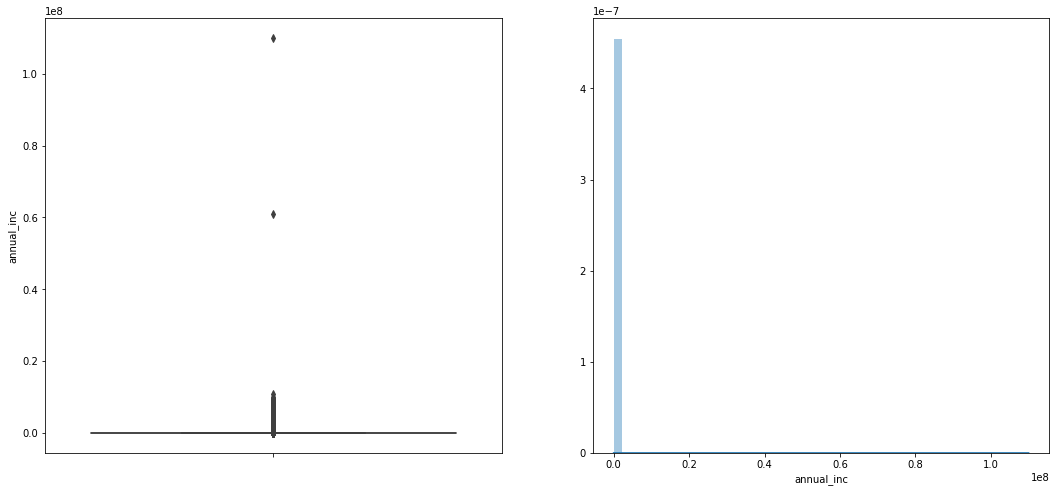

In [21]:
fig, ax = plt.subplots(1,2,figsize=(18, 8) )
sns.boxplot(data.annual_inc, orient="v", ax=ax[0])
sns.distplot(data.annual_inc, ax=ax[1])

In [21]:
data = data.loc[(data.annual_inc < 300000)]

Loan Amount

This variable looks fine

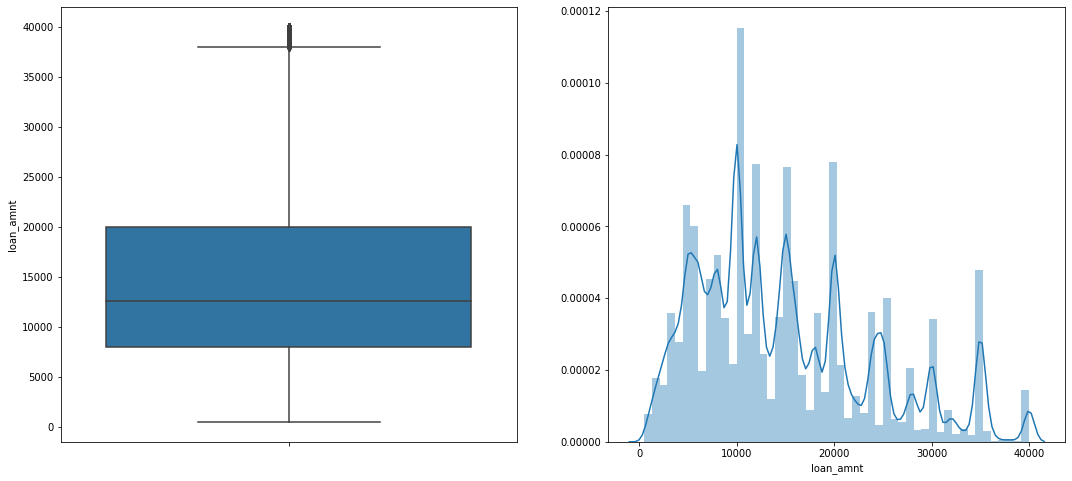

In [23]:
fig, ax = plt.subplots(1,2,figsize=(18, 8) )
sns.boxplot(data.loan_amnt, orient="v", ax=ax[0])
sns.distplot(data.loan_amnt, ax=ax[1])

Installment

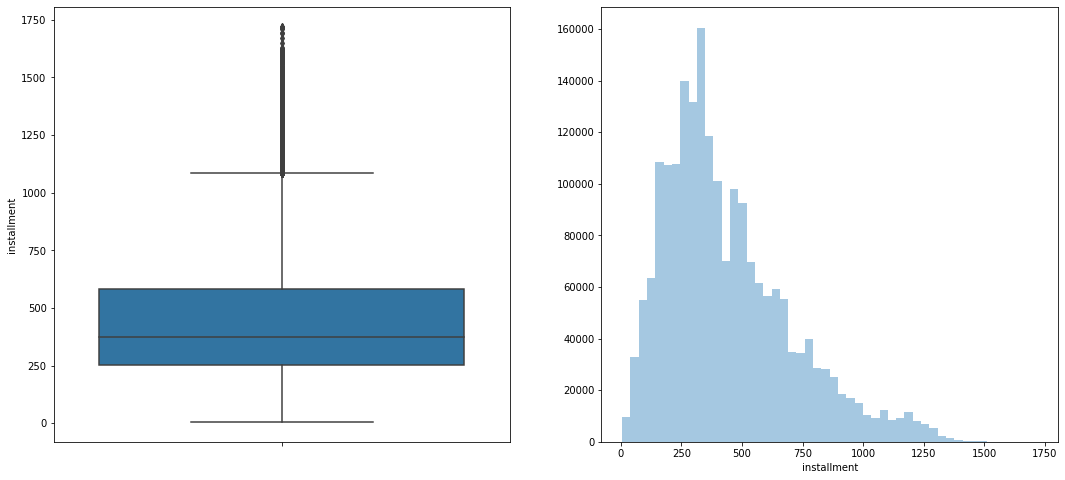

In [24]:
fig, ax = plt.subplots(1,2,figsize=(18, 8) )
sns.boxplot(data.installment, orient="v", ax=ax[0])
sns.distplot(data.installment, ax=ax[1], kde=False)

In [22]:
data = data.loc[(data.installment < 1600)]

DTI

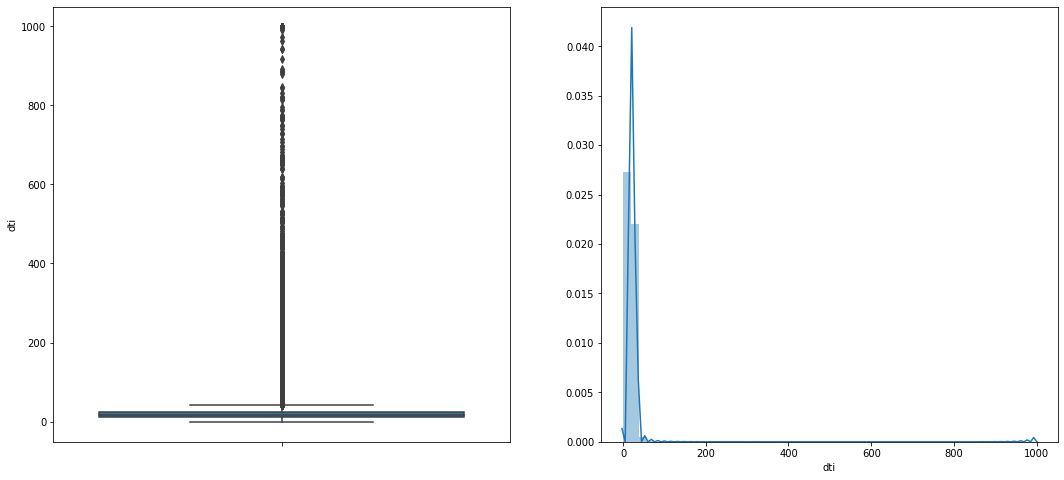

In [26]:
fig, ax = plt.subplots(1,2, figsize=(18, 8))
sns.boxplot(data.dti, orient="v", ax=ax[0])
sns.distplot(data.dti,ax=ax[1])

In [23]:
data = data.loc[(data.dti < 80)]

In [28]:
data.columns

Index(['default', 'loan_amnt', 'installment', 'emp_length', 'home_ownership',
       'purpose', 'annual_inc', 'term', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'mths_since_rcnt_il', 'inq_fi',
       'max_bal_bc'],
      dtype='object')

Delinq 2 years

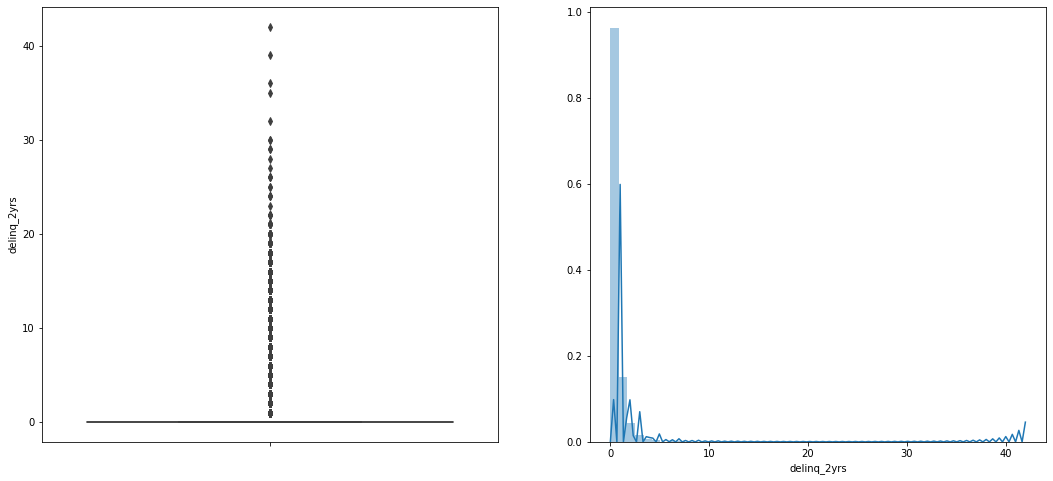

In [29]:
fig, ax = plt.subplots(1,2, figsize=(18, 8))
sns.boxplot(data.delinq_2yrs, orient="v", ax=ax[0])
sns.distplot(data.delinq_2yrs,ax=ax[1])

In [24]:
data = data.loc[(data.delinq_2yrs < 21)]
d2y = np.array(data[data.delinq_2yrs>0].delinq_2yrs.index)
data.loc[d2y.transpose(), "delinq_2yrs"] = 1

Inq Last 6 months

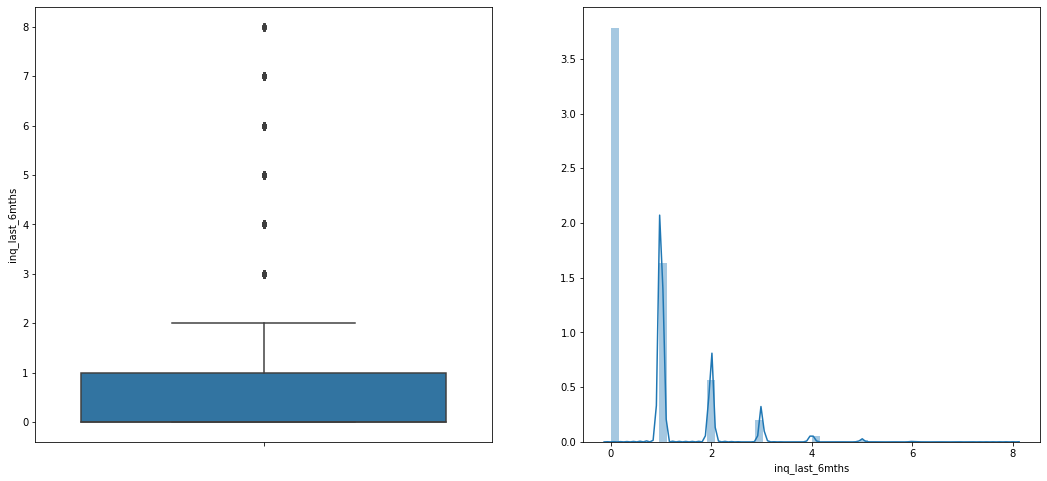

In [31]:
fig, ax = plt.subplots(1,2, figsize=(18, 8))
sns.boxplot(data.inq_last_6mths, orient="v", ax=ax[0])
sns.distplot(data.inq_last_6mths,ax=ax[1])

In [25]:
# They will be regroup in 0, 1 and greater than 2 
il6m = np.array(data[data.inq_last_6mths>=2].inq_last_6mths.index)
data.loc[il6m.transpose(), "inq_last_6mths"] = 2

Pub Rec

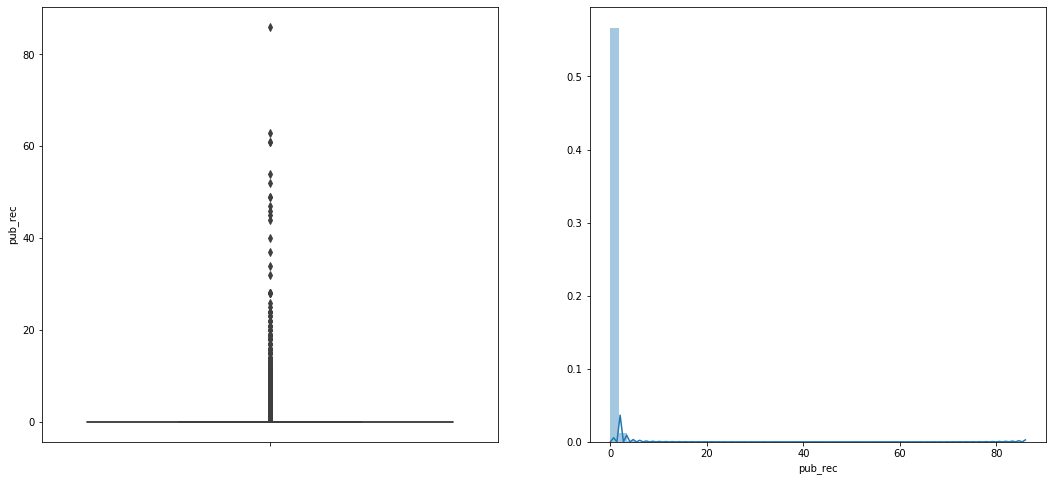

In [33]:
fig, ax = plt.subplots(1,2, figsize=(18, 8))
sns.boxplot(data.pub_rec, orient="v", ax=ax[0])
sns.distplot(data.pub_rec,ax=ax[1])

In [26]:
data = data.loc[(data.pub_rec < 6)]
pubrec = np.array(data[data.pub_rec>=1].inq_last_6mths.index)
data.loc[pubrec.transpose(), "pub_rec"] = 1

Open Acc

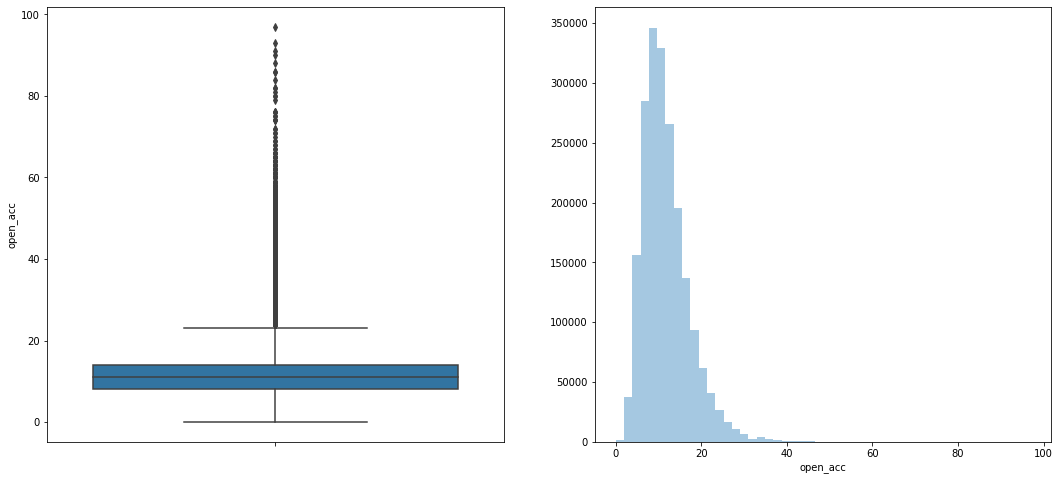

In [35]:
fig, ax = plt.subplots(1,2, figsize=(18, 8))
sns.boxplot(data.open_acc, orient="v", ax=ax[0])
sns.distplot(data.open_acc,ax=ax[1], kde=False)

In [27]:
data = data.loc[(data.open_acc < 50)]

Revol bal

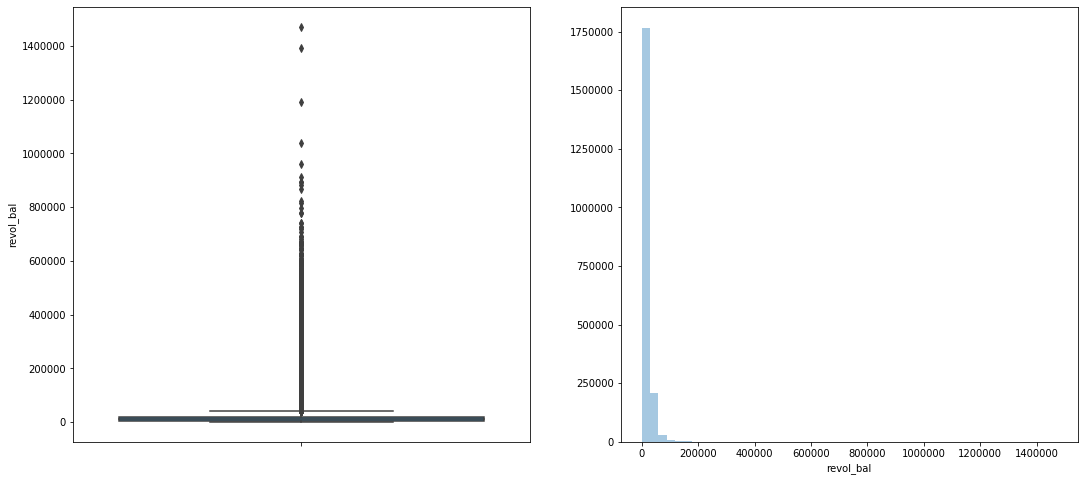

In [37]:
fig, ax = plt.subplots(1,2, figsize=(18, 8))
sns.boxplot(data.revol_bal, orient="v", ax=ax[0])
sns.distplot(data.revol_bal,ax=ax[1], kde=False)

In [28]:
data = data.loc[(data.revol_bal < 175000)]

Revol Util

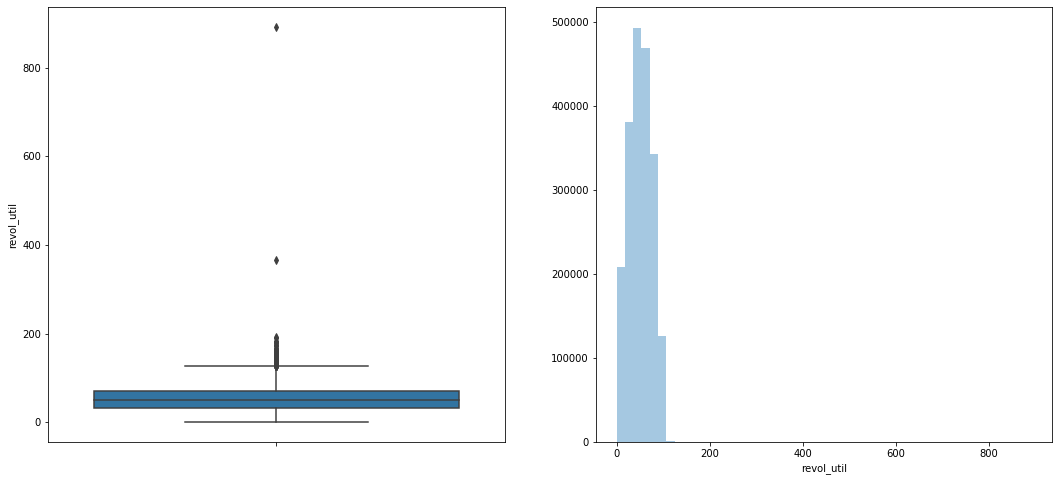

In [39]:
fig, ax = plt.subplots(1,2,figsize=(18, 8) )
sns.boxplot(data.revol_util, orient="v", ax=ax[0])
sns.distplot(data.revol_util,ax=ax[1], kde=False)

In [29]:
data = data.loc[(data.revol_util < 200)]

Total acc

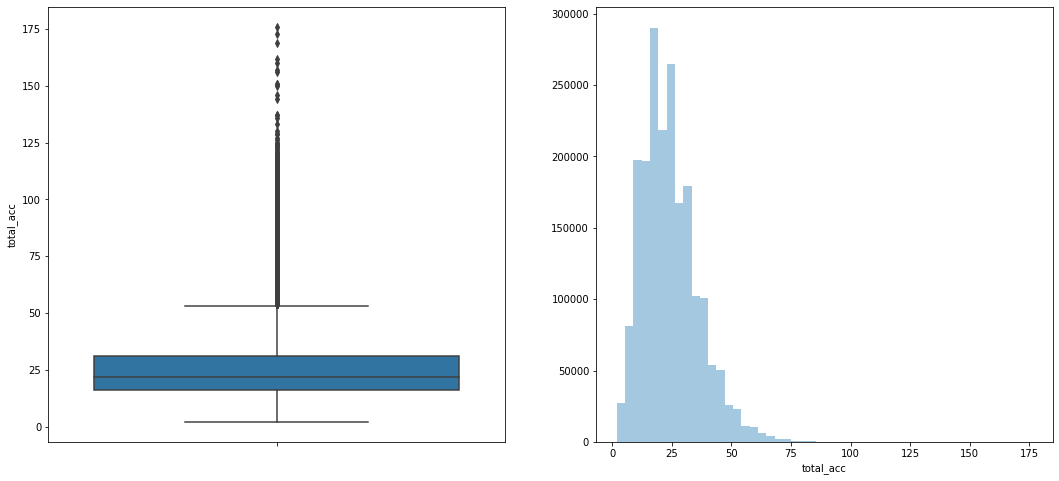

In [41]:
fig, ax = plt.subplots(1,2,figsize=(18, 8) )
sns.boxplot(data.total_acc, orient="v", ax=ax[0])
sns.distplot(data.total_acc,ax=ax[1], kde=False)

In [30]:
data = data.loc[(data.total_acc < 100)]

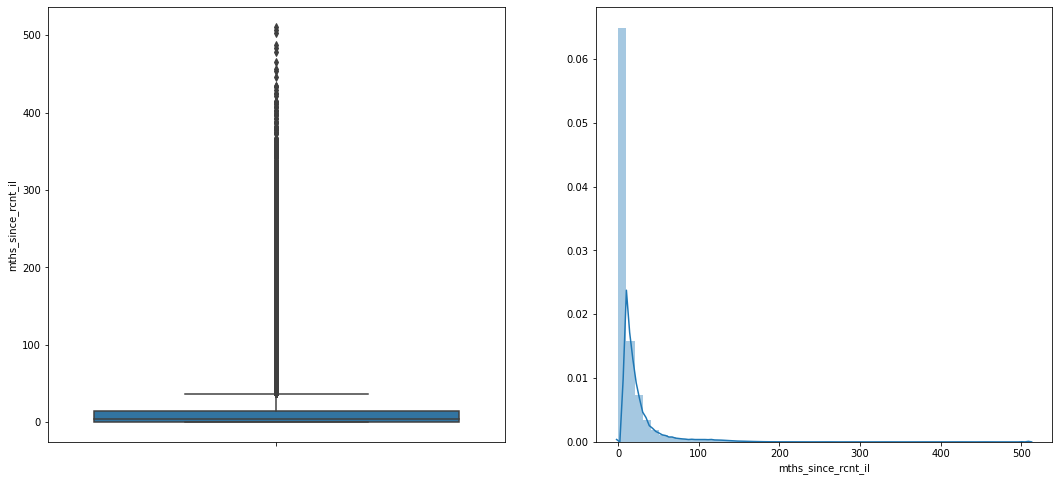

In [43]:
fig, ax = plt.subplots(1,2,figsize=(18, 8) )
sns.boxplot(data.mths_since_rcnt_il, orient="v", ax=ax[0])
sns.distplot(data.mths_since_rcnt_il,ax=ax[1])

In [31]:
data = data.loc[(data.mths_since_rcnt_il <=150)]

Inq fi

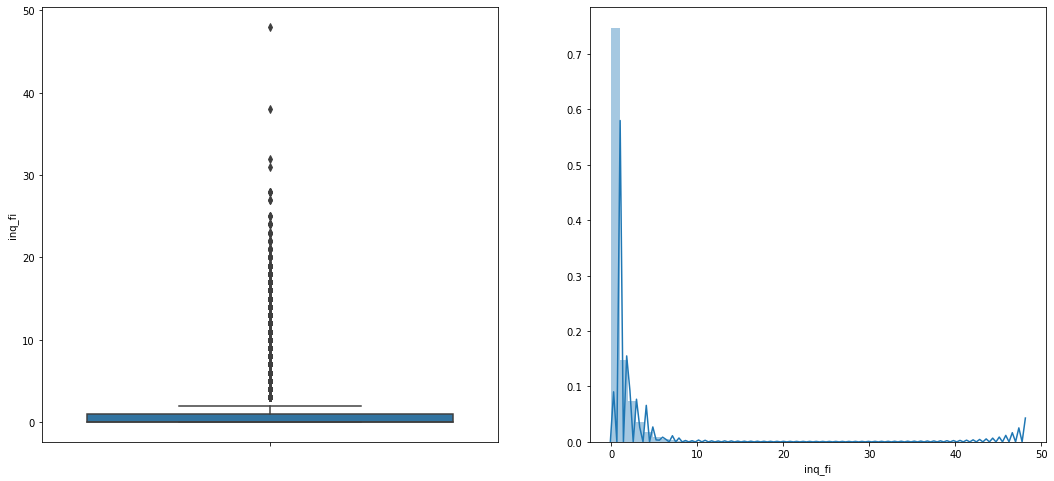

In [45]:
fig, ax = plt.subplots(1,2,figsize=(18, 8) )
sns.boxplot(data.inq_fi, orient="v", ax=ax[0])
sns.distplot(data.inq_fi,ax=ax[1])

Remove outliers greater than 10 and regrouped them 0,1,2 angreater or equal to 3

In [32]:
data = data.loc[(data.inq_fi <=10)]
inqfi = np.array(data[data.inq_fi>=3].inq_fi.index)
data.loc[inqfi.transpose(), "inq_fi"] = 3

Max_bal_bc

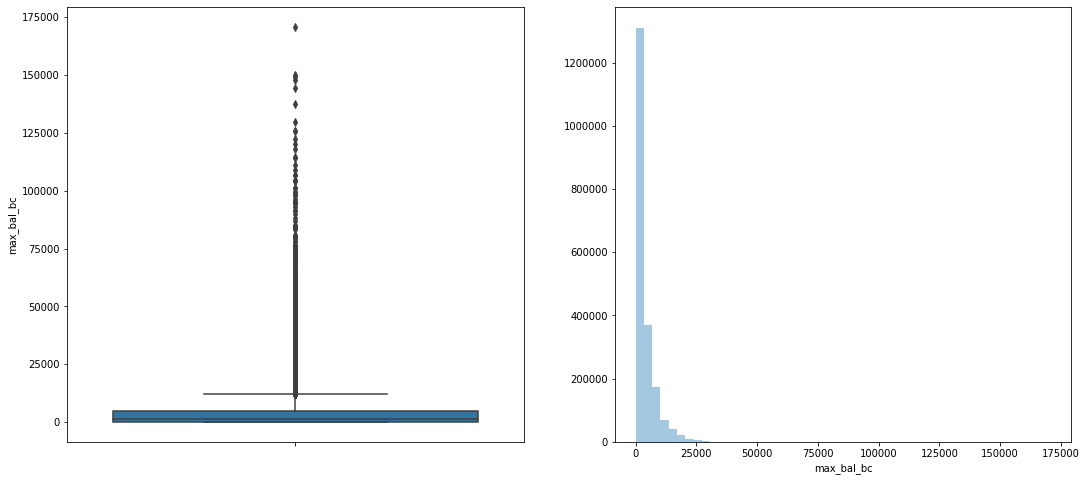

In [47]:
fig, ax = plt.subplots(1,2,figsize=(18, 8) )
sns.boxplot(data.max_bal_bc, orient="v", ax=ax[0])
sns.distplot(data.max_bal_bc,ax=ax[1], kde=False)

In [33]:
data = data.loc[(data.max_bal_bc <=40000)]

### Making some categorical variables significant

Some features contained multiple categories for this reason, new classes were created. One such example is purpose of the loans, it had 14 different values which some of them did not have enough cases. For this reason, these categories where grouped in two new groups living-leisure expenses or others. 

In [34]:
reg_dic = {"CT":"1", "ME":"1", "MA":"1", "NH":"1", "RI":"1", "VT":"1",
           "NY":"2", "NJ":"2", "PA":"2",
           "WI":"3", "MI":"3", "IL":"3", "IN":"3", "OH":"3",
           "ND":"4", "MN":"4", "SD":"4", "NE":"4", "IA":"4", "KS":"4", "MO":"4",
           "MD":"5", "DE":"5", "WV":"5", "DC":"5", "VA":"5", "NC":"5", "SC":"5", "GA":"5", "FL":"5",
           "KY":"6", "TN":"6", "AL":"6", "MS":"6", 
           "AR":"7", "OK":"7", "LA":"7", "TX":"7",
           "MT":"8", "ID":"8", "WY":"8", "NV":"8", "UT":"8", "CO":"8", "AZ":"8", "NM":"8",
           "WA":"9", "OR":"9", "CA":"9", "AK":"9", "HI":"9"
           }

data["addr_region"] = data.addr_state.map(reg_dic)

data.drop(["addr_state"], axis=1, inplace=True)

In [35]:
#Making homeownership significant
#We will add any other and none to the rent category

rent = np.array(data[(data.home_ownership == "ANY") | (data.home_ownership == "OTHER") | 
                     (data.home_ownership == "NONE")].home_ownership.index)

data.loc[rent.transpose(), "home_ownership"] = "RENT"

In [36]:
# Making the purpose columns significant
# Medical, car, vacation, moving, house, wedding, education will be put in a category call living_leasure_expenses 
# major_purchase, small_business and renewable_energy will be include in others

purpose1 = np.array(data[(data.purpose == "medical") | (data.purpose == "car") | (data.purpose == "vacation") |
                        (data.purpose == "moving") | (data.purpose == "house") | (data.purpose == "wedding") |
                        (data.purpose == "educational")].purpose.index)
data.loc[purpose1.transpose(), "purpose"] = "liv_leisure_exp"

purpose2 = np.array(data[(data.purpose == "small_business") | (data.purpose == "renewable_energy") | (data.purpose == "major_purchase")].purpose.index)
data.loc[purpose2.transpose(), "purpose"] = "other"

In [37]:
# Making emp_length to nominal values

m_dict = {
"emp_length": {
"10+ years": 10,
"9 years": 9,
"8 years": 8,
"7 years": 7,
"6 years": 6,
"5 years": 5,
"4 years": 4,
"3 years": 3,
"2 years": 2,
"1 year": 1,
"< 1 year": 0,
}}

data = data.replace(m_dict)

In [38]:
data = data.reset_index()
data.drop(["index"], inplace=True, axis=1)

In [40]:
# Encoding term 0 36, 60 1
data['term'] = data['term'].map({'36': 0, '60': 1})

In [42]:
data

,default,loan_amnt,installment,emp_length,home_ownership,purpose,annual_inc,term,zip_code,dti,...,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,mths_since_rcnt_il,inq_fi,max_bal_bc,addr_region
0,1,8000,245.05,10,MORTGAGE,credit_card,55000.0,0,984,17.83,...,0.0,12.0,0.0,10999,29.1,49.0,11.0,0.0,4663.0,9
1,1,6000,206.44,10,MORTGAGE,debt_consolidation,17000.0,0,342,19.99,...,0.0,8.0,0.0,650,8.3,10.0,11.0,3.0,202.0,5
2,1,10000,317.12,10,MORTGAGE,debt_consolidation,56000.0,0,852,20.53,...,1.0,7.0,1.0,10494,53.3,19.0,11.0,3.0,5295.0,8
3,1,10000,306.97,10,RENT,debt_consolidation,70000.0,1,612,11.37,...,1.0,4.0,0.0,3193,84.0,24.0,1.0,0.0,1568.0,3
4,1,4800,170.92,10,MORTGAGE,debt_consolidation,111000.0,0,231,13.35,...,0.0,12.0,0.0,2809,35.1,19.0,10.0,3.0,1322.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009782,0,12000,279.72,10,MORTGAGE,debt_consolidation,58000.0,1,054,20.88,...,0.0,12.0,0.0,9592,39.2,34.0,24.0,2.0,4052.0,1
2009783,0,12000,358.01,0,MORTGAGE,debt_consolidation,30000.0,1,971,19.28,...,1.0,10.0,0.0,3497,20.2,26.0,8.0,3.0,2238.0,9
2009784,0,10000,332.10,10,OWN,debt_consolidation,64000.0,0,603,12.96,...,0.0,6.0,0.0,7094,70.9,13.0,3.0,0.0,1864.0,3
2009785,0,12000,327.69,10,RENT,debt_consolidation,60000.0,1,996,30.82,...,1.0,8.0,0.0,12927,34.9,17.0,4.0,0.0,2406.0,9


We will take a sample of 500k cases to make the analysis

In [43]:
np.random.seed(0)
data3 = data.sample(40000)

In [44]:
# Downloading Data
data3.to_csv("data_40.csv",index=False)

## Modelling

The data is going to be divided in training and testing using n 

In [1]:
# Loading the packages
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, make_scorer, confusion_matrix, roc_curve, auc, roc_auc_score, precision_score
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.proportion import proportion_confint
from sklearn.linear_model import Lasso
from  sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from tqdm import tqdm

In [4]:
loan = pd.read_csv("data_40.csv")

# Getting dummy variables, is that ok? 
loan = pd.get_dummies(loan,drop_first=True)

In [47]:
loan.shape

(40000, 25)

In [48]:
1-loan.default.mean()

0.871825

In [45]:
loan.columns

Index(['default', 'loan_amnt', 'installment', 'emp_length', 'annual_inc',
       'term', 'zip_code', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mths_since_rcnt_il',
       'inq_fi', 'max_bal_bc', 'addr_region', 'home_ownership_OWN',
       'home_ownership_RENT', 'purpose_debt_consolidation',
       'purpose_home_improvement', 'purpose_liv_leisure_exp', 'purpose_other'],
      dtype='object')

Before we begin modelling, it is important to obtain a baseline for the accuracy of our predictive models. 
Because our variable is binary, if we did not look at the data the probability of default is 0.5, hence the variance is given by P(X) = p(x)(1-p(x)) << 0.5, and $sigma$ << 0.25. Thus the maximum of this will be used to estimate the size of our test set

 Mean squarred error: 0.500
  Std of squarred error: 0.500


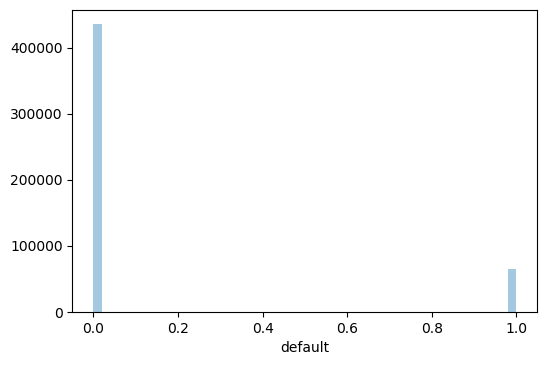

In [5]:
error_mean = 0.5
error_std = 0.5
print(f" Mean squarred error: {error_mean:.3f}")
print(f"  Std of squarred error: {error_std:.3f}")


fig, ax = plt.subplots(dpi=100)
sns.distplot(loan.default, kde=False)

We will estimate the performance of the final selected model to within +/- 0.01 for more precise results.

With a 95% of confidence we used $n = (\dfrac{2\sigma_l}{d})^2$ to calculate the size of the test set, where 0.01 is the margin of error.

In [6]:
n_test = ((2*0.5)/.01)**2
print(f'Test set size:{n_test}')
#.001 for more precise res

Test set size:10000.0


The test size resulted is 10000, however it was decided that the data would be divided 70/30 in training and test respectively

In [5]:
# Define our X and y
y = loan.default
X = loan.drop('default', axis = 'columns')

# Split into train&validation, test
# Random state assures that folds are consistent across models
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = 10000, random_state = 0)

**Dummy Classifier** 

Dummy classifier will be used as a based line performance, the expected success rate even if simply guessing. This means that any other classifier is expected to out perform its success rate.

In [9]:

strategies = ['most_frequent', 'stratified', 'uniform'] 
  
test_scores = [] 
for s in strategies: 
    if s =='constant': 
        dclf = DummyClassifier(strategy = s, random_state = 0) 
    else: 
        dclf = DummyClassifier(strategy = s, random_state = 0) 
    dclf.fit(Xtrain, ytrain) 
    score = dclf.score(Xtest, ytest) 
    test_scores.append(score) 


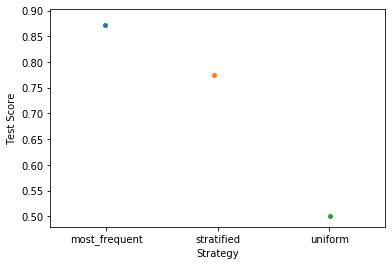

In [10]:

ax = sns.stripplot(strategies, test_scores); 
ax.set(xlabel ='Strategy', ylabel ='Test Score') 
plt.show() 


## Logistic Regression


The first model will be fitted using lasso as penalization. This will help us to understand the importance of each of the variables. 

A pipeline will be created using standar scaler to normalized the data and logistic regression. 

In [83]:
lgr_pipe1 = Pipeline([
    ('normalizer', StandardScaler()),
    ('logistic', LogisticRegression(penalty='l1', # Type of penalization l1 = lasso, l2 = ridge
                                     tol=0.0001, # Tolerance for parameters
                                     C=1, # Penalty constant, see below
                                     fit_intercept=True, # Use constant?
                                     class_weight='balanced', # Weights, see below
                                     max_iter=1000, # Maximum iterations
                                     verbose=0, # Show process. 1 is yes.
                                     solver = 'saga',
                                     n_jobs =-1,
                                     warm_start=False))
])

In [52]:
model1 = lgr_pipe1.fit(Xtrain, ytrain)


In [53]:
model_lg = model1.named_steps['logistic']

In [54]:
lg_coef = model_lg.coef_
lg_coef

array([[-1.51334907e+00,  1.55070226e+00,  1.03495270e-02,
        -2.10032439e-01,  6.33377550e-01, -9.89000603e-02,
         7.08676836e-02,  5.37596424e-02,  1.58128918e-01,
         7.90410370e-02,  8.88358925e-02, -7.92723936e-02,
         2.42828961e-01,  2.30117008e-02, -9.59867427e-02,
         3.25080574e-05, -2.20480504e-01,  1.27840560e-01,
         6.79037189e-02,  1.39967036e-01,  6.87798709e-02,
         5.46231508e-03,  2.25521756e-02,  7.13776362e-02]])

Looking for best parameters with gridsearch

In [84]:
def lgr_gs(score=recall_score):
    lams = np.linspace(0.01, 10, 25)

    param_grid = {'logistic__C': 1/lams}

    lgr_gscv = GridSearchCV(lgr_pipe1, 
                              param_grid=param_grid, 
                              cv = 5,
                              scoring=make_scorer(score),
                              n_jobs=-1,
                              iid = True)
    return lgr_gscv

**Recall**

In [85]:
lgr_recall = lgr_gs(recall_score).fit(Xtrain, ytrain);
print(f'Lasso model recall is {lgr_recall.best_score_:.2f}')

Lasso model recall is 0.63


In [57]:
print(f'Lasso C is {lgr_recall.best_params_}')

Lasso C is {'logistic__C': 0.14992503748125938}


In [58]:
lgr_recall.best_estimator_.named_steps["logistic"].coef_

array([[-1.45663492,  1.49895327,  0.00929864, -0.20959185,  0.61806343,
        -0.09266202,  0.0714243 ,  0.05334966,  0.15865047,  0.07814693,
         0.08858955, -0.07941832,  0.24259647,  0.02178187, -0.09561176,
         0.        , -0.21974896,  0.12159451,  0.06681429,  0.13909391,
         0.06718477,  0.00390163,  0.02113282,  0.07001376]])

In [191]:
# CV Results for Recall
cv_best_score_recall = lgr_recall.cv_results_['mean_test_score'][lgr_recall.cv_results_['mean_test_score'] == lgr_recall.best_score_]

# Std error of the best estimator
cv_std_best_score_recall = lgr_recall.cv_results_['std_test_score'][lgr_recall.cv_results_['mean_test_score'] == lgr_recall.best_score_]/np.sqrt(5)
cv_std_best_score_recall


array([0.01060745])

In [183]:
lr_mean_score = lgr_recall.cv_results_['mean_test_score']
lr_std_score = lgr_recall.cv_results_['std_test_score'] / np.sqrt(5)

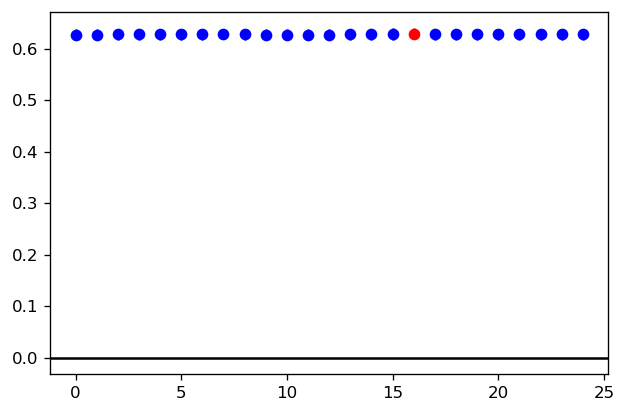

In [189]:
idx = np.arange(0,25)
fig, ax = plt.subplots(dpi = 120)
    
# If the interval crosses this line, it should be blue, else red.
for i in range(25):            
    if (lr_mean_score[i] == cv_best_score_recall):
        ax.errorbar(idx[i], lr_mean_score[i],
                    fmt='or',yerr=lr_std_score[i],ecolor='r')
    else:
        ax.errorbar(idx[i], lr_mean_score[i],
                    fmt='ob',yerr=lr_std_score[i],ecolor='b')
ax.axhline(0, color = 'k')

In [60]:
coef_col = list(Xtrain.columns)
coefficients = pd.DataFrame(coef_col, columns=["Variable"])
coefficients["coef_val"] = lg_coef.transpose()
coefficients

,Variable,coef_val
0,loan_amnt,-1.513349
1,installment,1.550702
2,emp_length,0.010350
3,annual_inc,-0.210032
4,term,0.633378
5,zip_code,-0.098900
6,dti,0.070868
7,delinq_2yrs,0.053760
8,inq_last_6mths,0.158129
9,open_acc,0.079041


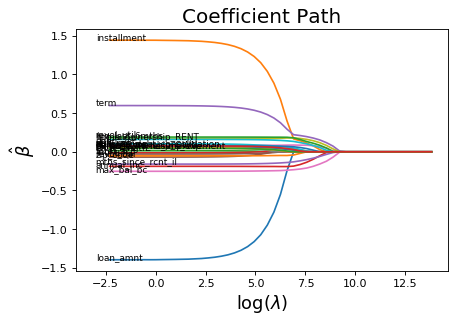

In [19]:
# 1)
regularization_strength = np.logspace(-1, 6, 50)

coefs = np.zeros((regularization_strength.size, X.shape[1]))

# 2)
for i,L in enumerate(regularization_strength):
    lasso_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('logistic_reg', LogisticRegression(penalty = 'l1', 
                                               solver='liblinear', 
                                               max_iter=1000,
                                               C = 1.0/L)) # Note, C = 1/lambda from question 3
    ])
    
    lasso_pipe.fit(Xtrain, ytrain)
    coefs[i] = lasso_pipe.named_steps['logistic_reg'].coef_

# 3)

fig, ax = plt.subplots(dpi = 80)
ax.plot(np.log(regularization_strength), coefs)
ax.set_xlabel(r'$\log(\lambda)$', fontsize = 16)
ax.set_ylabel(r'$\hat{\beta}$', fontsize = 16)
ax.set_title('Coefficient Path', fontsize = 18)
ax.set_xlim(-4,None)

for i, name in enumerate(Xtrain.columns[:-1]):
    
    ax.annotate(name, xy = (-3, coefs[0,i]), ha = 'left', fontsize = 8)

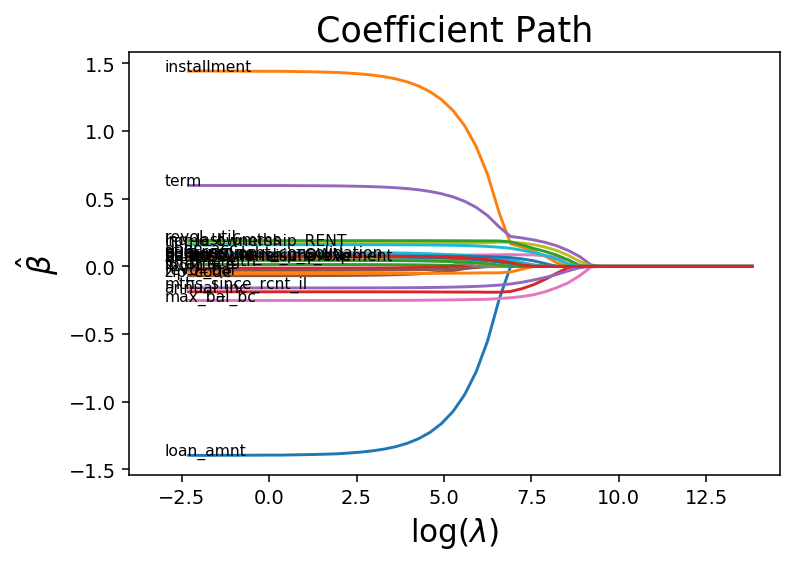

In [44]:
fig, ax = plt.subplots(dpi = 140)
ax.plot(np.log(regularization_strength), coefs)
ax.set_xlabel(r'$\log(\lambda)$', fontsize = 16)
ax.set_ylabel(r'$\hat{\beta}$', fontsize = 16)
ax.set_title('Coefficient Path', fontsize = 18)
ax.set_xlim(-4,None)

for i, name in enumerate(Xtrain.columns[:-1]):
    
    ax.annotate(name, xy = (-3, coefs[0,i]), ha = 'left', fontsize = 8)

stderrorof th 5 cv /sqrt(5) 

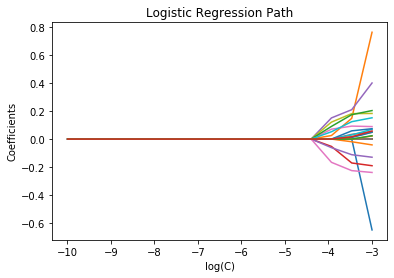

In [52]:
from sklearn.svm import l1_min_c
cs = l1_min_c(Xtrain, ytrain, loss='log') * np.logspace(0, 7, 16)
coef = []
for c in cs:
    lgr_model1.named_steps['logistic'].set_params(C=c)
    model = lgr_model1.fit(Xtrain, ytrain)
    par = model.named_steps['logistic'].coef_.ravel().copy()
    coef.append(par)
coef = np.array(coef)

plt.plot(np.log10(cs), coef) #marker='o'
ymin, ymax = plt.ylim()
plt.xlim(-5,-3)
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.axis('tight')
plt.show()

**Precision**

In [192]:
lgr_precision = lgr_gs(precision_score).fit(Xtrain, ytrain);
print(f'Lasso model precision is {lgr_precision.best_score_:.2f}')

print(f'Lasso C is {lgr_precision.best_params_}')

Lasso model precision is 0.20
Lasso C is {'logistic__C': 2.3460410557184748}


In [46]:
lgr_precision.best_estimator_.named_steps["logistic"].coef_

array([[-1.46176408,  1.50041317,  0.00993821, -0.18658641,  0.6235715 ,
        -0.07088433,  0.08684099,  0.06036909,  0.17773054,  0.09990864,
         0.07977947, -0.04466627,  0.20539538, -0.01028756, -0.13783281,
        -0.02139499, -0.24164975,  0.07357102,  0.06385286,  0.16326063,
         0.07248643,  0.04939381,  0.04562161,  0.07923147]])

In [195]:
# CV Results for Recall
cv_best_score_precision = lgr_precision.cv_results_['mean_test_score'][lgr_precision.cv_results_['mean_test_score'] == lgr_precision.best_score_]
cv_std_best_score_precision = lgr_precision.cv_results_['std_test_score'][lgr_precision.cv_results_['mean_test_score'] == lgr_precision.best_score_]/np.sqrt(5)
cv_best_score_precision,cv_std_best_score_precision

(array([0.20347509]), array([0.003311]))

#### Confussion Matrix of the Logistic Regression Model

In [86]:
ypred_model1 = lgr_recall.predict(Xtrain)

In [15]:
def plot_confusion_matrix(y_true, y_pred, classes=np.array([0.0,1.0]), normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    ax.axis('equal')
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout();
    return ax, cm

Confusion matrix, without normalization
Accuracy: 0.6387333333333334 Precision: 0.20482334092250612 Recall: 0.6330466510294501


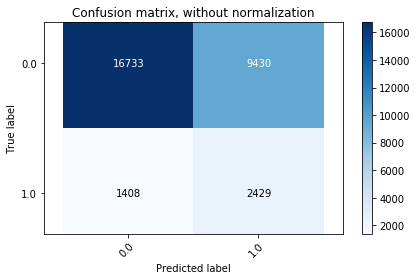

In [87]:
def plot_confusion_matrix(y_true, y_pred, classes=np.array([0.0,1.0]), normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    ax.axis('equal')
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout();
    return ax, cm

cm = plot_confusion_matrix(ytrain, ypred_model1)

tn=cm[1][0][0]
fp=cm[1][0][1]
fn=cm[1][1][0]
tp=cm[1][1][1]

acc = (tn+tp) / (tn+tp+fp+fn)
prec = (tp) / (tp+fp)
rec = (tp) / (tp+fn)
print("Accuracy:", acc, "Precision:", prec, "Recall:",rec )



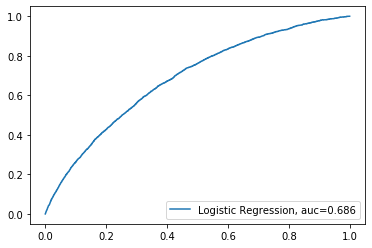

In [114]:
# Calculate the ROC curve points

# Apply the model to the test set.
ypredt1 = lgr_recall.predict(Xtrain)
probs_test = lgr_recall.predict_proba(Xtrain)

fpr, tpr, thresholds = roc_curve(ytrain, probs_test[:,1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = ytrain, 
                             y_score = probs_test[:,1]),
              decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Super Vector Machines

#### Using Linear Kernel

In [215]:
svm_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('svm', SVC(kernel='linear', gamma='auto',  class_weight='balanced', probability=True))
])

In [216]:
svm_model = svm_pipe.fit(Xtrain, ytrain)

Confusion matrix, without normalization
Accuracy: 0.6451333333333333 Precision: 0.20556948888696705 Recall: 0.6194943966640605


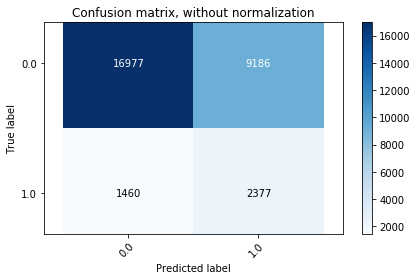

In [74]:
ypred_svm = svm_model.predict(Xtrain)

cm = plot_confusion_matrix(ytrain, ypred_svm)
tn=cm[1][0][0]
fp=cm[1][0][1]
fn=cm[1][1][0]
tp=cm[1][1][1]

acc = (tn+tp) / (tn+tp+fp+fn)
prec = (tp) / (tp+fp)
rec = (tp) / (tp+fn)
print("Accuracy:", acc, "Precision:", prec, "Recall:",rec )

In [75]:
cv_scores_smv_linear = cross_val_score(svm_pipe, Xtrain, ytrain, cv = 5, scoring=make_scorer(recall_score))

In [78]:
cv_scores_smv_linear.mean()

0.6127139015645371

In [89]:
cvscores_smv_linear_pre = cross_val_score(svm_pipe, Xtrain, ytrain, cv = 5, scoring=make_scorer(precision_score))

In [90]:
cvscores_smv_linear_pre.mean()

0.2048492908993636

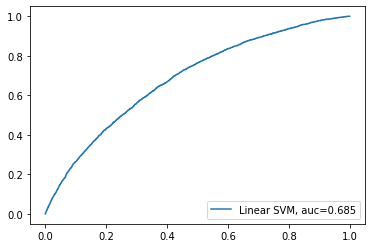

In [115]:

# Calculate the ROC curve points

# Apply the model to the test set.
ypred_svm = svm_model.predict(Xtrain)
probs_test_svm = svm_model.predict_proba(Xtrain)

fpr, tpr, thresholds = roc_curve(ytrain, probs_test_svm[:,1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = ytrain, 
                             y_score = probs_test_svm[:,1]),
              decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Linear SVM, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### SVM RBF

We believe that this kernel is overfitting the data, the results after cross-validation did not match the values of the confusion matrix. 

In [108]:
svm_pipe_rbf = Pipeline([
    ('scale', StandardScaler()),
    ('svm', SVC(kernel='rbf', gamma='auto', class_weight="balanced", probability=True))
])

In [109]:
svm_modelrbf = svm_pipe_rbf.fit(Xtrain, ytrain)

In [103]:
recall_score(ytrain,ypred_svmrbf)

0.7902006776127183

In [104]:
roc_auc_score(ytrain,ypred_svmrbf)

0.7369953814237961

Confusion matrix, without normalization
Accuracy: 0.6974 Precision: 0.2681999115435648 Recall: 0.7902006776127183


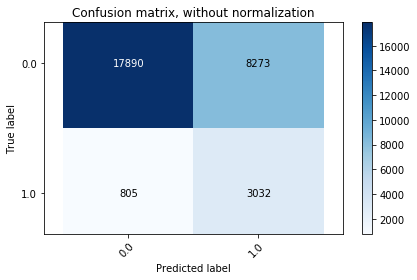

In [110]:
ypred_svmrbf = svm_modelrbf.predict(Xtrain)

cm = plot_confusion_matrix(ytrain, ypred_svmrbf)
tn=cm[1][0][0]
fp=cm[1][0][1]
fn=cm[1][1][0]
tp=cm[1][1][1]

acc = (tn+tp) / (tn+tp+fp+fn)
prec = (tp) / (tp+fp)
rec = (tp) / (tp+fn)
print("Accuracy:", acc, "Precision:", prec, "Recall:",rec )


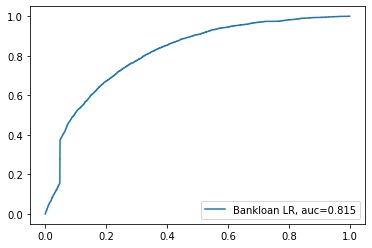

In [113]:

# Calculate the ROC curve points

# Apply the model to the test set.
ypred_svmrbf = svm_modelrbf.predict(Xtrain)
probs_test_svmrbf = svm_modelrbf.predict_proba(Xtrain)

fpr, tpr, thresholds = roc_curve(ytrain, probs_test_svmrbf[:,1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = ytrain, 
                             y_score = probs_test_svmrbf[:,1]),
              decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Bankloan LR, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [95]:
cvscores_smv_rbf = cross_val_score(svm_pipe_rbf, Xtrain, ytrain, cv = 5, scoring=make_scorer(recall_score))

In [97]:
cvscores_smv_rbf

array([0.56119792, 0.60546875, 0.57366362, 0.59061278, 0.60495437])

In [106]:
cvscores_smv_rbf_roc = cross_val_score(svm_pipe_rbf, Xtrain, ytrain, cv = 5, scoring=make_scorer(roc_auc_score))

In [107]:
cvscores_smv_rbf_roc

array([0.60479158, 0.63676839, 0.61780831, 0.62548605, 0.63504599])

#### Parameter Tunning

This was not perform because it was taken more 24 hrs to run even when we reduced the sample to 40,000 cases

In [8]:
#tuned_params = {'svm__gamma':np.linspace(0.01, 10, 25), 'svm__kernel':['rbf','linear']}
tuned_params = {'svm__gamma':np.linspace(0.01, 10, 25)}
grid_svm = GridSearchCV(estimator=svm_pipe, scoring="recall", param_grid = tuned_params, cv=5)



In [26]:
tuned_params = {'svm__gamma':np.linspace(0.01, 10, 5)}
grid_svmrbf = GridSearchCV(estimator=svm_pipe_rbf, scoring="recall", param_grid = tuned_params, cv=5)


In [9]:
smv_gscv =grid_svm.fit(Xtrain,ytrain)

In [27]:
smv_gscvrbf =grid_svmrbf.fit(Xtrain,ytrain)

### Random Forest

In [126]:
rf1_pipe = Pipeline([
    ('normalizer', StandardScaler()),
    ('rf', RandomForestClassifier(n_estimators=1000, # Number of trees to train
                       criterion='gini', # How to train the trees. Also supports entropy.
                       max_depth=None, # Max depth of the trees. Not necessary to change. #You may want to put a limit on it 
                       min_samples_split=2, # Minimum samples to create a split. 
                       min_samples_leaf=0.001, # Minimum samples in a leaf. Accepts fractions for %. This is 0.1% of sample.#Control the amount of time play with this 
                       min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                       max_features='auto', # Maximum number of features per split (not tree!) by default is sqrt(vars)
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.0001, # Minimum impurity decrease. This is 10^-3.
                       bootstrap=True, # If sample with repetition.
                       oob_score=True,  # If report accuracy with non-selected cases.
                       n_jobs=-1, # Parallel processing. Set to -1 for all cores. Watch your RAM!!
                       random_state=251082976, # Seed
                       verbose=1, # If to give info during training. Set to 0 for silent training.
                       warm_start=False, # If train over previously trained tree.
                       class_weight='balanced'
                                    ))])

In [205]:
# Do not run this

n = np.array([500,1000])
max_f = np.array([1,2,3,4,5])
#min_sam = np.array([2,3])
param_grid = {'rf__max_features': max_f,'rf__n_estimators':n}

rf_gscv = GridSearchCV(rf1_pipe, 
                          param_grid=param_grid, 
                          cv = 5,
                          scoring=make_scorer(roc_auc_score
                                             
                                             ),
                          n_jobs=-1,
                          iid = True)
rf_gscv.fit(Xtrain, ytrain)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('normalizer',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('rf',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight='balanced',
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0001,
      

In [206]:
rf_gscv.best_params_

{'rf__max_features': 1, 'rf__n_estimators': 500}

In [207]:
rf_gscv.best_score_

0.6109131543392922

In [149]:
ypred_rfgs = rf_gscv.predict(Xtrain)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.9s finished


Confusion matrix, without normalization
Accuracy: 0.6777 Precision: 0.22526851328434144 Recall: 0.6231430805316653


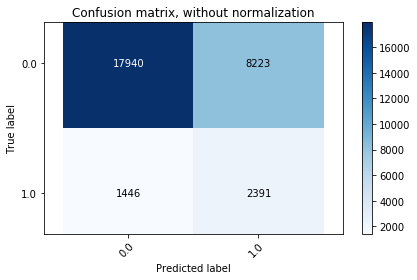

In [208]:
cm = plot_confusion_matrix(ytrain, ypred_rfgs)

tn=cm[1][0][0]
fp=cm[1][0][1]
fn=cm[1][1][0]
tp=cm[1][1][1]

acc = (tn+tp) / (tn+tp+fp+fn)
prec = (tp) / (tp+fp)
rec = (tp) / (tp+fn)
print("Accuracy:", acc, "Precision:", prec, "Recall:",rec )


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.4s finished


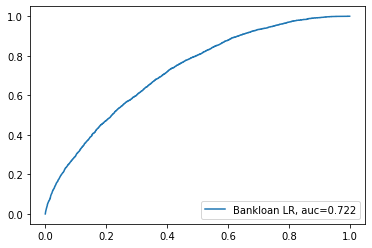

In [212]:

# Calculate the ROC curve points

# Apply the model to the test set.
ypred_rfgs = rf_gscv.predict(Xtrain)
probs_test_rfgs = rf_gscv.predict_proba(Xtrain)

fpr, tpr, thresholds = roc_curve(ytrain, probs_test_rfgs[:,1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = ytrain, 
                             y_score = probs_test_rfgs[:,1]),
              decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Bankloan LR, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [213]:
for name, importance in zip(Xtrain.columns, rf_gscv.best_estimator_.named_steps["rf"].feature_importances_):
  print(name, "= %.2f" % importance)

loan_amnt = 0.05
installment = 0.06
emp_length = 0.02
annual_inc = 0.07
term = 0.07
zip_code = 0.04
dti = 0.08
delinq_2yrs = 0.01
inq_last_6mths = 0.06
open_acc = 0.03
pub_rec = 0.02
revol_bal = 0.06
revol_util = 0.09
total_acc = 0.03
mths_since_rcnt_il = 0.11
inq_fi = 0.02
max_bal_bc = 0.11
addr_region = 0.02
home_ownership_OWN = 0.00
home_ownership_RENT = 0.03
purpose_debt_consolidation = 0.02
purpose_home_improvement = 0.01
purpose_liv_leisure_exp = 0.00
purpose_other = 0.00


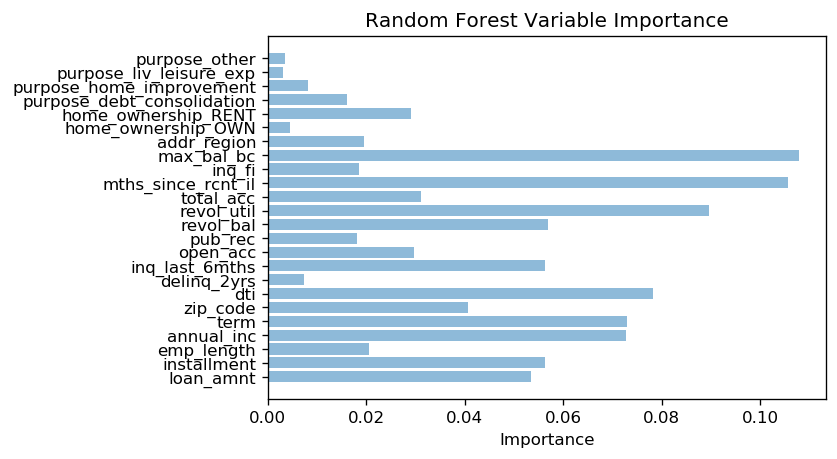

In [217]:
rf_var_imp = rf_gscv.best_estimator_.named_steps["rf"].feature_importances_
fig, ax = plt.subplots(dpi = 120)
plt.barh(Xtrain.columns, rf_var_imp,
        align='center', alpha=0.5)
plt.yticks(Xtrain.columns)
plt.xlabel('Importance')
plt.title('Random Forest Variable Importance')
plt.show()

**CV standard errors**

In [209]:
# CV Results for Recall
cv_best_score_rf = rf_gscv.cv_results_['mean_test_score'][rf_gscv.cv_results_['mean_test_score'] == rf_gscv.best_score_]

# Std error of the best estimator
cv_std_best_score_rf = rf_gscv.cv_results_['std_test_score'][rf_gscv.cv_results_['mean_test_score'] == rf_gscv.best_score_]/np.sqrt(5)
cv_std_best_score_rf


array([0.00345872])

In [210]:
rf_mean_score = rf_gscv.cv_results_['mean_test_score']
rf_std_score = rf_gscv.cv_results_['std_test_score'] / np.sqrt(5)

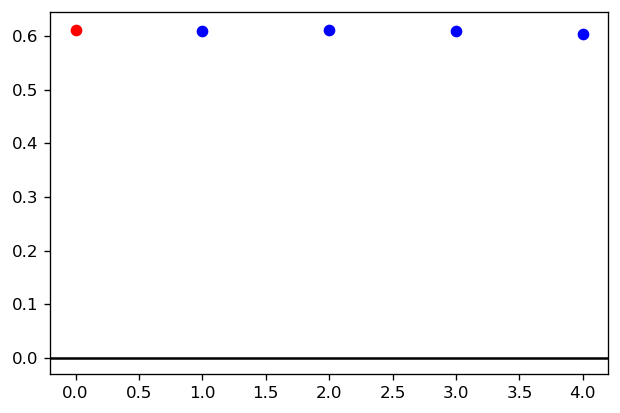

In [211]:
idx = np.arange(0,5)
fig, ax = plt.subplots(dpi = 120)
    
# If the interval crosses this line, it should be blue, else red.
for i in range(5):            
    if (rf_mean_score[i] == cv_best_score_rf):
        ax.errorbar(idx[i], rf_mean_score[i],
                    fmt='or',yerr=rf_std_score[i],ecolor='r')
    else:
        ax.errorbar(idx[i], rf_mean_score[i],
                    fmt='ob',yerr=rf_std_score[i],ecolor='b')
ax.axhline(0, color = 'k')

### AUROC

Using the trainig set

In [ ]:
ypred_rfgs = rf_gscv.predict(Xtrain)
probs_test_rfgs = rf_gscv.predict_proba(Xtrain)

fpr, tpr, thresholds = roc_curve(ytrain, probs_test_rfgs[:,1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = ytrain, 
                             y_score = probs_test_rfgs[:,1]),
              decimals = 3)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.4s finished


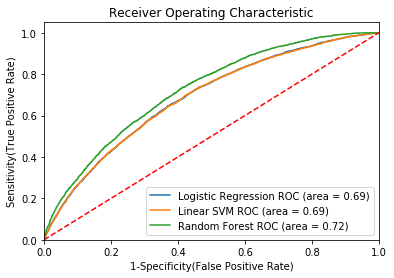

In [224]:
plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': lgr_recall,
},
{
    'label': 'Linear SVM',
    'model': svm_model,
},
{
    'label': 'Random Forest',
    'model': rf_gscv,
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    y_pred=model.predict(Xtrain) # predict the test data
    proba = model.predict_proba(Xtrain)[:,1]
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(ytrain, proba)
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(ytrain, proba)
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

**Expected Loss**

The expected loss was calculated given that each model predicted correctly the defaulters

In [240]:
loss_dic = {}
for m in models:
    model = m['model'] # select the model
    y_pred=model.predict(Xtrain) # predict the test data
    proba = model.predict_proba(Xtrain)[:,1]
    loss = round(sum(Xtrain.loan_amnt * proba * y_pred)/1000000,2)
    loss_dic[m['label']] = loss

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.4s finished


In [241]:
pd.DataFrame(loss_dic, index = ['Expected Loss'])

,Logistic Regression,Linear SVM,Random Forest
Expected Loss,118.7,39.04,89.74


## Selected Model & Result over the Test Set

In [253]:
best_model_pred = rf_gscv.predict(Xtest)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.4s finished


Confusion matrix, without normalization
Accuracy: 0.6667 Precision: 0.21119592875318066 Recall: 0.5790697674418605


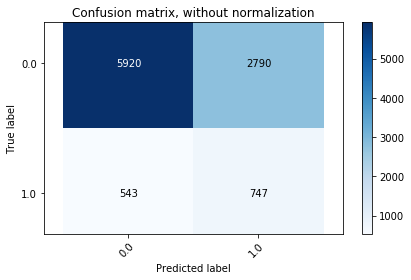

In [254]:
cm = plot_confusion_matrix(ytest, best_model_pred )

tn=cm[1][0][0]
fp=cm[1][0][1]
fn=cm[1][1][0]
tp=cm[1][1][1]

acc = (tn+tp) / (tn+tp+fp+fn)
prec = (tp) / (tp+fp)
rec = (tp) / (tp+fn)
print("Accuracy:", acc, "Precision:", prec, "Recall:",rec )


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.3s finished


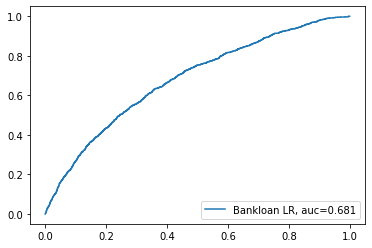

In [255]:
# Apply the model to the test set.
probs_best_model = rf_gscv.predict_proba(Xtest)

fpr, tpr, thresholds = roc_curve(ytest, probs_best_model[:,1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = ytest, 
                             y_score = probs_best_model[:,1]),
              decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Bankloan LR, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [257]:
loss_rf = round((sum(Xtest.loan_amnt * probs_best_model[:,1] * best_model_pred)/1000000),2)
print(f"Expected Loss",loss_rf)

Expected Loss 29.86
